# Introduction 

This project analyses data from the past competition "ieee-fraud-detection" on Kaggle. The goal of this project is to learn how to approach more complicated tasks which can be useful in different work environments.

The work done here uses the EDA of users Alijs, Chris Deotte and Konstantin Yakovlev

https://www.kaggle.com/code/alijs1/ieee-transaction-columns-reference/notebook

https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id/notebook#NAN-search


**Data sources:**

The datasets can be found at  https://www.kaggle.com/competitions/ieee-fraud-detection

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
            'id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']


In [3]:
# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [4]:
#RELEVANT VCOLS ACCORDING TO THE EDA DONE BY ALIJIS, CHRIS DEOTTE AND KONSTANTIN YAKLOVEV 
V_cols = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30',
          'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68',
          'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V107', 'V108', 'V111', 'V115', 'V117',
          'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156',
          'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
          'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223',
          'V224', 'V226', 'V228', 'V229', 'V234', 'V235', 'V238', 'V240', 'V250', 'V252', 'V253', 'V257', 'V258',
          'V260', 'V261', 'V264', 'V266', 'V267', 'V271', 'V274', 'V277', 'V281', 'V283', 'V284', 'V285', 'V286',
          'V289', 'V291', 'V294', 'V296', 'V297', 'V301', 'V303', 'V305', 'V307', 'V309', 'V310', 'V314', 'V320' ]


cols += V_cols
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float'
for c in str_type: 
    dtypes[c] = 'category'

In [6]:
# LOAD TRAIN
train_transaction = pd.read_csv('train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_identity = pd.read_csv('train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
# LOAD TEST
test_transaction= pd.read_csv('test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_identity = pd.read_csv('test_identity.csv',index_col='TransactionID', dtype=dtypes)
id_labels = {x:n for x, n in zip(test_identity.columns, train_identity.columns)}
test_identity.rename(columns=id_labels, inplace=True)
X_test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# TARGET (There is no isFraud column in the test datasets)
y_train = X_train['isFraud'].copy()
del X_train['isFraud']
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)


In [11]:
#NORMALIZE THE D-COLUMNS. THESE ARE DELTA TIMES 
for column in ['D' + str(i) for i in range(1,16) ]:
    X_train[column] = X_train[column] - X_train['TransactionDT']/(24*3600) 
    X_test[column] = X_test[column] - X_train['TransactionDT']/(24*3600)

In [12]:

for index, column in enumerate(X_train.columns):
    if (str(X_train[column].dtype) == 'category') or (X_train[column].dtype == 'object'):
        pass
    elif column not in ['TransactionAmt', 'TransactionDT']:
        minim = np.min((X_train[column].min(), X_test[column].min()))
        X_train[column] -= minim
        X_test[column] -= minim
        X_train[column].fillna(-1, inplace =True)
        X_test[column].fillna(-1, inplace=True)

In [13]:
# REMOVE THE FOLLOWING COLUMNS AS THE PERCENTAGE OF NAN VALUES IS MORE THAN 87%
cols_remove = []
for column in train_transaction.columns:
    na_count = train_transaction[column].isna().sum()/len(train_transaction[column])*100
    if na_count > 87 and column != 'dist2':
        cols_remove.append(column)
print(cols_remove)

['D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14']


In [14]:
# LOCAL VALIDATION: TRAIN 75% PREDICT 25%
index_T = X_train.index[:3*len(X_train)//4]
index_V = X_train.index[3*len(X_train)//4:]

In [15]:
import xgboost as xgb

In [16]:
cols = list(X_train.columns)
for j in cols_remove:
    cols.remove(j)
xgb_clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist', 
        enable_categorical=True, 
        early_stopping_rounds=100) 

In [17]:
h = xgb_clf.fit(X_train.loc[index_T,cols], y_train[index_T], 
        eval_set=[(X_train.loc[index_V,cols],y_train[index_V])],
        verbose=50)

[0]	validation_0-auc:0.80665
[50]	validation_0-auc:0.86259
[100]	validation_0-auc:0.87257
[150]	validation_0-auc:0.88549
[200]	validation_0-auc:0.89618
[250]	validation_0-auc:0.90320
[300]	validation_0-auc:0.90980
[350]	validation_0-auc:0.91373
[400]	validation_0-auc:0.91648
[450]	validation_0-auc:0.91829
[500]	validation_0-auc:0.91901
[550]	validation_0-auc:0.91996
[600]	validation_0-auc:0.92021
[650]	validation_0-auc:0.92066
[700]	validation_0-auc:0.92101
[750]	validation_0-auc:0.92083
[800]	validation_0-auc:0.92079
[817]	validation_0-auc:0.92062


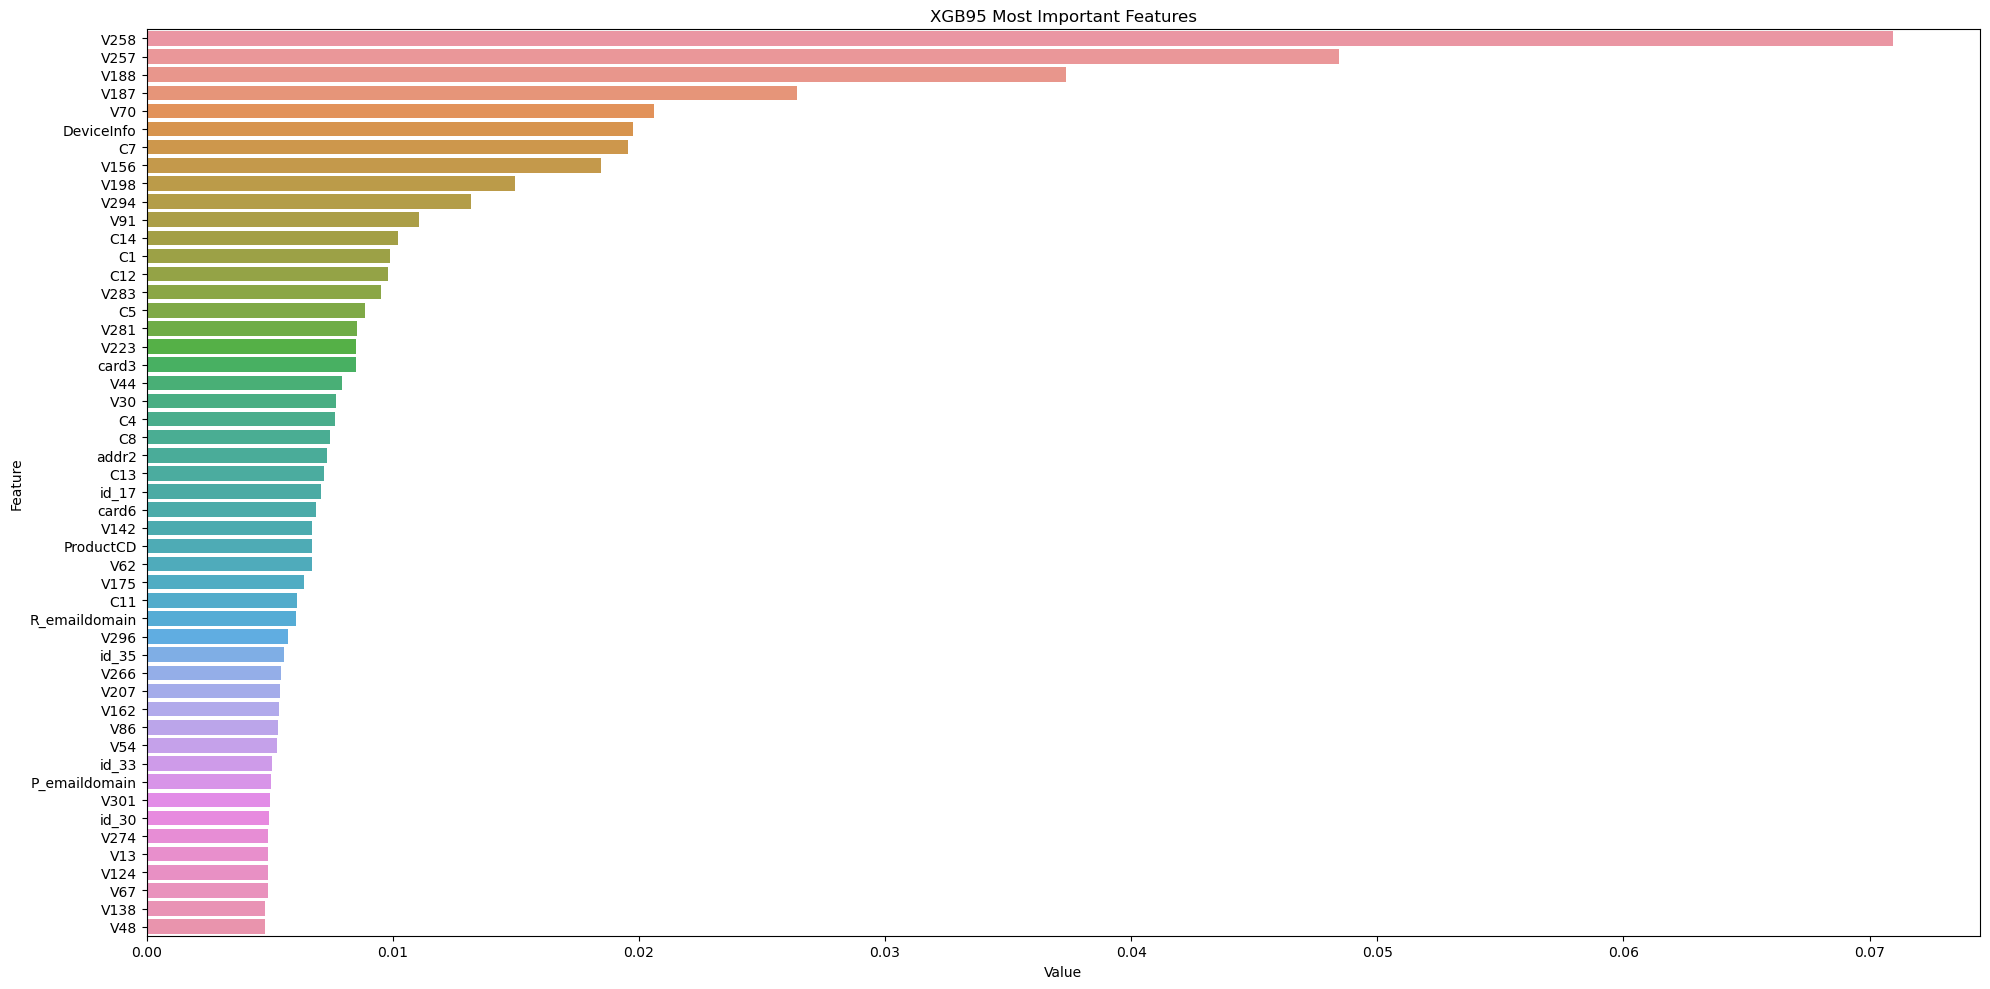

In [18]:
#FEATURE IMPORTANCE
feature_importance = pd.DataFrame(sorted(zip(xgb_clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

We predict `test.csv` using GroupKFold with months as groups. The training data are the months December 2017, January 2018, February 2018, March 2018, April 2018, and May 2018. We refer to them as 12, 13, 14, 15, 16, 17. Fold one in GroupKFold will train on months 13 thru 17 and predict month 12. This is used to get an idea of when to tell XGB to stop using early stopping rounds. Also, at the moment of the competition this meant backwrdas in time which was irrelevant.

The model trained on months 13 thru 17 will also predict test.csv which at the moment were forward in time.

Note that we use local validation to determine features but GroupKFold to predict test.csv. 

We got an accuracy of 93% in the training data. We don't have the values for isFraud of the test data sets as they are not anymore available in the competition page on Kaggle.

In [20]:
# Collect the month from the delta time column TransactionDT
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))
#PREDICT WITH GROUPKFOLD
skf = GroupKFold(n_splits=6)
for i, (index_T, index_V) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[index_V]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(index_T),'rows of holdout =',len(index_V))
    clf = xgb.XGBClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        tree_method='gpu_hist', 
        enable_categorical=True,
        early_stopping_rounds=200)        
    h = clf.fit(X_train[cols].iloc[index_T], y_train.iloc[index_T], 
                eval_set=[(X_train[cols].iloc[index_V],y_train.iloc[index_V])],
                verbose=100)
    
    oof[index_V] += clf.predict_proba(X_train[cols].iloc[index_V])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
print('#'*20)
print ('OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.81565
[100]	validation_0-auc:0.86505
[200]	validation_0-auc:0.88700
[300]	validation_0-auc:0.90013
[400]	validation_0-auc:0.90762
[500]	validation_0-auc:0.91000
[600]	validation_0-auc:0.91106
[700]	validation_0-auc:0.91104
[800]	validation_0-auc:0.91132
[900]	validation_0-auc:0.91138
[1000]	validation_0-auc:0.91089
[1100]	validation_0-auc:0.91008
[1118]	validation_0-auc:0.91008
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.82796
[100]	validation_0-auc:0.88951
[200]	validation_0-auc:0.91220
[300]	validation_0-auc:0.92608
[400]	validation_0-auc:0.93212
[500]	validation_0-auc:0.93469
[600]	validation_0-auc:0.93614
[700]	validation_0-auc:0.93641
[800]	validation_0-auc:0.93664
[900]	validation_0-auc:0.93644
[994]	validation_0-auc:0.93611
Fold 2 withholding month 13
 rows of train = 497955 rows of holdout = 92585
[0]	validation_0-auc:0.8260

Note that there are many things which can be done to improve this modele such as performing feature encoding in the category variables or used the method called magic features (https://www.kaggle.com/code/cdeotte/xgb-fraud-with-magic-0-9600/notebook)  which the winners used to get an accuracy of 96% on the training set and 94% on the test data.